## NLP Assignment #3 - Luke Schwenke

In [165]:
import pandas as pd
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import jaccard
from nltk import TweetTokenizer
from nltk.stem import WordNetLemmatizer

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

### Determine which news articles (news_df) are similar to each other and which tweets (tweets_df) are more similar to each other.  In order to accomplish this you need to create n-grams and compare the similarity of the text using Jaccard distance.

#### Read news data

In [166]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_3_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True, encoding='utf-8')

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 1,018 news articles


,url,date,language,title,text
0,https://auto.hindustantimes.com/lml-bikes/dealers/bodh-gaya,2022-01-21,en,Lml Bikes Car Dealers - Lml Bikes Showrooms in India,"Lml Bikes Car Dealers - Lml Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar NewsBik..."
1,https://auto.hindustantimes.com/pure-ev-bikes/dealers/avadi,2022-01-21,en,Pure Ev Bikes Car Dealers - Pure Ev Bikes Showrooms in India,"Pure Ev Bikes Car Dealers - Pure Ev Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar..."


#### Read Tweets data

In [167]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_3_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 1,020 tweets


,id,lang,date,name,retweeted,text
0,1491880241782005777,en,2022-02-10,Sir Botalot dropping the Mike!,,@singervehicles Will you do a straight swap for my Renault Twingo 1.2 Extreme? \n\nThat is awesome! 🔥
1,1501237946590142469,en,2022-03-08,Sabrina Ghio,RT,"Australian GP Qualifying, Melbourne, 8th March 1997. #F1 The Grid ⬇️\n\nRow 3:\n5. Eddie Irvine (Ferrari) +2.512s\n6. Mika Hakkinen (McLaren-Mercedes) +2.602s\n\nRow 4:\n7. Johnny Herbert (Sauber-Petronas) +2.918s\n8. Jean Alesi (Benetton-Renault) +3.224s https://t.co/i4IC4LzVVN"


### Cleaning / Preparation

In [168]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
def clean_text(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags (but keep the text after #)
    text = re.sub(r'#', '', text)
    # Remove RT (retweet symbol)
    text = re.sub(r'RT[\s]+', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/\S+', '', text)
    # Remove newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove carriage return characters
    text = re.sub(r'\r', '', text)
    # Remove "&amp;"
    text = re.sub(r'&amp;', '', text)
    # Remove other special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Optionally, remove single characters (mostly left from removing mentions and hashtags)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Convert multiple spaces to a single space
    text = re.sub(r'\s+', ' ', text)
    # Optionally, convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text.strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lmschwenke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [169]:
tweets_df['text_clean'] = tweets_df['text'].apply(clean_text)
news_df['text_clean'] = news_df['text'].apply(clean_text)
news_df['title_clean'] = news_df['title'].apply(clean_text)

In [170]:
# Examine a cleaned sample tweet
tweets_df['text_clean'][0]

'straight swap renault twingo extreme awesome'

In [171]:
# Examine a cleaned sample news article
news_df['text_clean'][0][0:100]

'lml bikes car dealers lml bikes showrooms india explore friday january log insign searchnotification'

In [172]:
news_df['title_clean'][0]

'lml bikes car dealers lml bikes showrooms india'

In [173]:
# Create clean dataset copies
news_df_c = news_df
tweets_df_c = tweets_df

### Define a function that will create n number of ngram columns

In [174]:
def create_ngrams(text, n=10):
    n_grams = list(nltk.ngrams(text, n))
    return n_grams

## Section #1: Tweets

### Start by tokenizing the tweets

In [175]:
def tweet_tokenize(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

### Lemmatize the tokens to the root word

In [176]:
tweets_df_c['tokens'] = tweets_df_c['text_clean'].apply(tweet_tokenize)

# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
tweets_df_c['tokens'] = tweets_df_c['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

tweets_df_c.head(5)

,id,lang,date,name,retweeted,text,text_clean,tokens
0,1491880241782005777,en,2022-02-10,Sir Botalot dropping the Mike!,,@singervehicles Will you do a straight swap for my Renault Twingo 1.2 Extreme? \n\nThat is awesome! 🔥,straight swap renault twingo extreme awesome,"[straight, swap, renault, twingo, extreme, awesome]"
1,1501237946590142469,en,2022-03-08,Sabrina Ghio,RT,"Australian GP Qualifying, Melbourne, 8th March 1997. #F1 The Grid ⬇️\n\nRow 3:\n5. Eddie Irvine (Ferrari) +2.512s\n6. Mika Hakkinen (McLaren-Mercedes) +2.602s\n\nRow 4:\n7. Johnny Herbert (Sauber-Petronas) +2.918s\n8. Jean Alesi (Benetton-Renault) +3.224s https://t.co/i4IC4LzVVN",australian gp qualifying melbourne th march grid row eddie irvine ferrari mika hakkinen mclarenmercedes row johnny herbert sauberpetronas jean alesi benettonrenault,"[australian, gp, qualifying, melbourne, th, march, grid, row, eddie, irvine, ferrari, mika, hakkinen, mclarenmercedes, row, johnny, herbert, sauberpetronas, jean, alesi, benettonrenault]"
2,1505982695129718784,en,2022-03-21,Colin N. Walker 🏴󠁧󠁢󠁳󠁣󠁴󠁿 🇪🇺💙😷 #FBPE,RT,#BoycottRenault\n\nThink of the blood of thousands of Ukrainian women and children pouring from every Renault car. \n\nhttps://t.co/rbU01Sy9DU,boycottrenault think blood thousands ukrainian women children pouring every renault car,"[boycottrenault, think, blood, thousand, ukrainian, woman, child, pouring, every, renault, car]"
3,1516744110463463426,en,2022-04-20,Yvette Lissman,RT,"Almost 200,000 workers in Russia still on western payrolls\n\nMcDonald’s, IKEA, Renault, Levi Strauss, &amp;others pay salaries to thousands of their employees while their operations in🇷🇺are suspended\nCoca-Cola, Yum Brands,KFC didn't confirm if they still pay🇷🇺s https://t.co/KWDhCo1dM0",almost workers russia still western payrolls mcdonalds ikea renault levi strauss others pay salaries thousands employees operations inare suspended cocacola yum brandskfc didnt confirm still pays,"[almost, worker, russia, still, western, payroll, mcdonalds, ikea, renault, levi, strauss, others, pay, salary, thousand, employee, operation, inare, suspended, cocacola, yum, brandskfc, didnt, confirm, still, pay]"
4,1493777143347630086,en,2022-02-16,Andile Xaba 🇿🇦,RT,Take a selfie with the New #Renault #ClioV and WIN R1000 fuel voucher 💥 tag @tableviewrenault &amp; #renaulttableviewcliov random winner announced 28.02.2022 @BradAtRenault 0825662336 to book a test drive 🇿🇦 https://t.co/D7V2GnJa8B,take selfie new renault cliov win fuel voucher tag renaulttableviewcliov random winner announced book test drive,"[take, selfie, new, renault, cliov, win, fuel, voucher, tag, renaulttableviewcliov, random, winner, announced, book, test, drive]"


### Create n number of ngrams columns based on the lemmatized token tweets

In [185]:
for i in range(1, 11):
    tweets_df_c['ngrams_'+str(i)] = tweets_df_c['tokens'].apply(create_ngrams, n=i)

In [178]:
tweets_df_c.head(1)

,id,lang,date,name,retweeted,text,text_clean,tokens,ngrams_1,ngrams_2,ngrams_3,ngrams_4,ngrams_5,ngrams_6,ngrams_7,ngrams_8,ngrams_9
0,1491880241782005777,en,2022-02-10,Sir Botalot dropping the Mike!,,@singervehicles Will you do a straight swap for my Renault Twingo 1.2 Extreme? \n\nThat is awesome! 🔥,straight swap renault twingo extreme awesome,"[straight, swap, renault, twingo, extreme, awesome]","[(straight,), (swap,), (renault,), (twingo,), (extreme,), (awesome,)]","[(straight, swap), (swap, renault), (renault, twingo), (twingo, extreme), (extreme, awesome)]","[(straight, swap, renault), (swap, renault, twingo), (renault, twingo, extreme), (twingo, extreme, awesome)]","[(straight, swap, renault, twingo), (swap, renault, twingo, extreme), (renault, twingo, extreme, awesome)]","[(straight, swap, renault, twingo, extreme), (swap, renault, twingo, extreme, awesome)]","[(straight, swap, renault, twingo, extreme, awesome)]",[],[],[]


In [179]:
from nltk.metrics import jaccard_distance

def calculate_jaccard_distance(ngrams1, ngrams2):
    # Convert n-gram lists to sets
    set_ngrams1 = set(ngrams1)
    set_ngrams2 = set(ngrams2)

    distance = 1 - jaccard_distance(set_ngrams1, set_ngrams2)

    return distance

In [180]:
def compute_max_jaccard(df, num):
    # Create new columns for storing the highest Jaccard similarity and corresponding index for each row
    df['highest_sim_'+str(num)] = 0.0  # Initialize with 0.0 (no similarity)
    df['highest_sim_ind_'+str(num)] = -1  # Initialize with -1 (no index)

    from itertools import combinations

    # Iterate over all unique pairs of rows in the dataframe
    for i, j in combinations(df.index, 2):
        # Calculate Jaccard similarity, handle cases with empty n-grams
        if len(df['ngrams_'+str(num)][i]) == 0 or len(df['ngrams_'+str(num)][j]) == 0:
            similarity = 0  # If either n-gram set is empty, similarity is 0
        else:
            # Calculate Jaccard similarity for non-empty n-gram sets
            similarity = calculate_jaccard_distance(df.at[i, 'ngrams_'+str(num)], df.at[j, 'ngrams_'+str(num)])

        # Ignore perfect matches (similarity = 1), considering them as zero similarity
        if similarity == 1:
            similarity = 0

        # Update the record for the highest similarity for each row
        # If current similarity is higher than the stored value, update it along with the index of the compared row
        if similarity > df.at[i, 'highest_sim_'+str(num)]:
            df.at[i, 'highest_sim_ind_'+str(num)] = j  # Update index
            df.at[i, 'highest_sim_'+str(num)] = similarity  # Update similarity score

        if similarity > df.at[j, 'highest_sim_'+str(num)]:
            df.at[j, 'highest_sim_ind_'+str(num)] = i  # Update index for the other row in the pair
            df.at[j, 'highest_sim_'+str(num)] = similarity  # Update similarity score

    # At the end of this function, each row in df will have the highest Jaccard similarity
    # and the index of the row with which this highest similarity is achieved.


In [186]:
for i in range(1,11):
    compute_max_jaccard(tweets_df_c, i)

In [188]:
sim_columns

Index(['highest_sim_1', 'highest_sim_2', 'highest_sim_3', 'highest_sim_4',
       'highest_sim_5', 'highest_sim_6', 'highest_sim_7', 'highest_sim_8',
       'highest_sim_9', 'highest_sim_10'],
      dtype='object')

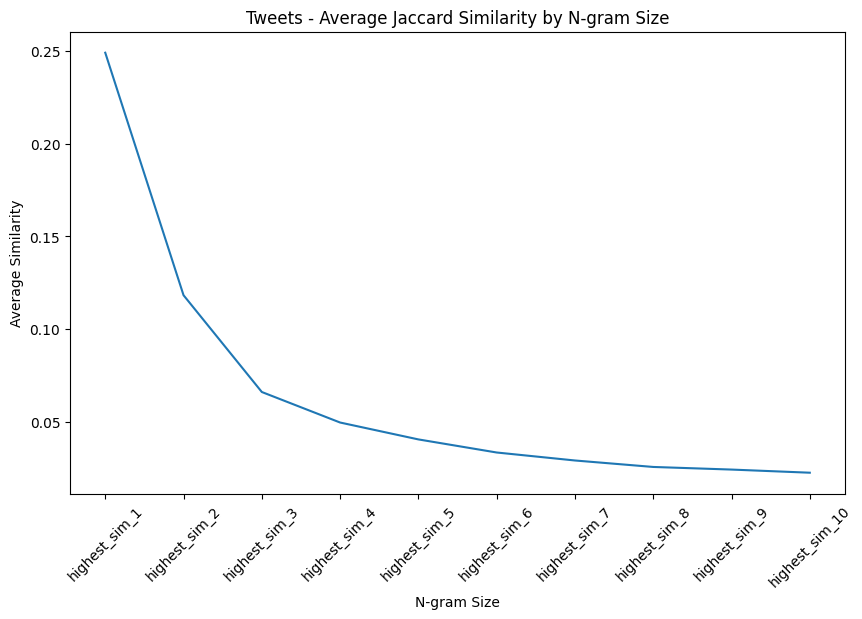

In [189]:
import matplotlib.pyplot as plt

sim_columns = tweets_df_c.filter(regex='^highest_sim_\d+').columns
avg_sim = tweets_df_c[sim_columns].mean()

# Plot using seaborn's lineplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
sns.lineplot(data=avg_sim)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel('N-gram Size')  # Set title for the x-axis
plt.ylabel('Average Similarity')  # Set title for the y-axis
plt.title('Tweets - Average Jaccard Similarity by N-gram Size')  # Set the title of the plot
plt.show()

### Based on the above plot, I would conclude an ngram value of 3 is best for tweets. This makes sense because ~5 is usually ideal for shorter texts whereas a higher number like 10 is better for long articles / books. So tweets aligning with n=3 seems correct.

In [190]:
tweets_df[['highest_sim_3','highest_sim_ind_3','text_clean','text']].nlargest(10, 'highest_sim_3')

,highest_sim_3,highest_sim_ind_3,text_clean,text
15,0.947368,378,renault kiger stunning yet muscular suv stance crafted complement free spirit renault cars nagercoil sportysmart renaultcars renaultindia bestcars buycarsnagercoil morespacing renaultkiger,Renault Kiger is stunning yet muscular SUV stance is crafted to complement your free spirit. \n#renault #cars #nagercoil #Sportysmart #renaultcars #renaultindia #bestcars #buycarsnagercoil #morespacing #renaultkiger https://t.co/0gaRyxca7h
378,0.947368,15,kiger stunning yet muscular suv stance crafted complement free spirit renault cars nagercoil sportysmart renaultcars renaultindia bestcars buycarsnagercoil morespacing renaultkiger,https://t.co/DFfqSVOypZ \nKiger is stunning yet muscular SUV stance is crafted to complement your free spirit.\n#renault #cars #nagercoil #Sportysmart #renaultcars #renaultindia #bestcars #buycarsnagercoil #morespacing #renaultkiger https://t.co/LzLJ0IjpyT
181,0.909091,877,cnn renault announced departure week russian auto market amid countrys war ukraine moscows mayor announced factory used restart defunct sovietera moskvich car brand via,"CNN: After Renault announced its departure this week from the Russian auto market amid the country's war with Ukraine, Moscow's mayor announced its factory will be used to restart the defunct Soviet-era Moskvich car brand. https://t.co/QtIpxQ9d6I (via https://t.co/lgfjwGPwdG )"
877,0.909091,181,renault announced departure week russian auto market amid countrys war ukraine moscows mayor announced factory used restart defunct sovietera moskvich car brand,"After Renault announced its departure this week from the Russian auto market amid the country's war with Ukraine, Moscow's mayor announced its factory will be used to restart the defunct Soviet-era Moskvich car brand. https://t.co/F3pRGrtYQX"
140,0.846154,659,reuters french automaker renault resumes production moscow march company decided resume operations country renault majority owner avtovaz russias largest car manufacturer famous lada brand,"⚡️ Reuters: French automaker Renault resumes production in Moscow.\n\nOn March 22, the company decided to resume operations in the country. Renault is the majority owner of AvtoVaz, Russia’s largest car manufacturer famous for the Lada brand."
241,0.846154,659,reuters french automaker renault resumes production moscow march company decided resume operations country renault majority owner avtovaz russias largest car manufacturer famous lada brand,"⚡️ Reuters: French automaker Renault resumes production in Moscow.\n\nOn March 22, the company decided to resume operations in the country. Renault is the majority owner of AvtoVaz, Russia’s largest car manufacturer famous for the Lada brand."
242,0.846154,659,reuters french automaker renault resumes production moscow march company decided resume operations country renault majority owner avtovaz russias largest car manufacturer famous lada brand,"⚡️ Reuters: French automaker Renault resumes production in Moscow.\n\nOn March 22, the company decided to resume operations in the country. Renault is the majority owner of AvtoVaz, Russia’s largest car manufacturer famous for the Lada brand."
406,0.846154,659,reuters french automaker renault resumes production moscow march company decided resume operations country renault majority owner avtovaz russias largest car manufacturer famous lada brand,"⚡️ Reuters: French automaker Renault resumes production in Moscow.\n\nOn March 22, the company decided to resume operations in the country. Renault is the majority owner of AvtoVaz, Russia’s largest car manufacturer famous for the Lada brand."
430,0.846154,659,reuters french automaker renault resumes production moscow march company decided resume operations country renault majority owner avtovaz russias largest car manufacturer famous lada brand,"⚡️ Reuters: French automaker Renault resumes production in Moscow.\n\nOn March 22, the company decided to resume operations in the country. Renault is th

### The highest similarity tweets are related to the french automatker, Renault cars, and mentions of Moscow.

In [191]:
non_zero_tweets = tweets_df[tweets_df['highest_sim_3'] > 0]
non_zero_tweets[['highest_sim_3','highest_sim_ind_3', 'text_clean', 'text']].nsmallest(10, 'highest_sim_3')

,highest_sim_3,highest_sim_ind_3,text_clean,text
667,0.019231,455,jean alesi finished nd first podium points since moving benettonrenault michael schumacher also took first podium finish points ferrari driver rd lap behind race winner damon hill brazilian gp interlagos st march,"Jean Alesi finished 2nd, his first podium &amp; points with since moving to Benetton-Renault. Michael Schumacher also took his first podium finish &amp; points as a Ferrari driver with 3rd in his F310, a lap behind race winner Damon Hill. Brazilian GP, Interlagos, 31st March 1996. #F1 https://t.co/IeJw2vLtnM"
664,0.022222,898,rothmans williamsrenault launch estoril chassis fw engine renault rs v tyres goodyear eagle damon hill jacques villeneuve test driver jeanchristophe boullion,"Rothmans Williams-Renault Launch, Estoril, 1996. #F1 🇬🇧🇫🇷\nChassis: FW18\nEngine: Renault RS8, 3.0L V10\nTyres: Goodyear Eagle F1 \n5. Damon Hill 🇬🇧\n6. Jacques Villeneuve 🇨🇦\nTest Driver: Jean-Christophe Boullion 🇫🇷 https://t.co/giO693pk7r"
898,0.022222,664,mild seven renault car launch event monaco chassis engine mecachromebuilt renault rs v naturally aspirated power hp rpm weight kg tyres michelin points race wins podiums world titles elplan,"Mild Seven Renault F1 2005 car launch event at Monaco\n\nChassis R25\nEngine Mecachrome-built Renault RS25 3.0 L V10 72° naturally aspirated\nPower 800–900 hp @ 19,000 RPM\nWeight 605 kg\nTyres Michelin\n\n191 points, 8 race wins, 15 podiums and 2 World Titles\n\n#elPlan https://t.co/L77Oh42TCZ"
641,0.023810,877,car news today mr va auto legendary sovietera moskvich car could revived renault exit mr va auto car buying hero autoblog news car check autoblogs news,Car News of Today 🚗\nMr VA Auto\n.\n'Legendary' Soviet-era Moskvich car could be revived after Renault exit\n.\nMr VA Auto - Your Car Buying Hero\nhttps://t.co/MWNhcYg5LC\n#AutoBlog #News #Car\nhttps://t.co/tNfYThIk8q\ncheck out all AutoBlogs news here\nhttps://t.co/fptnjBqips https://t.co/unQ3D4o0j2
771,0.023810,1012,michael schumacher mild seven benettonrenault lap qualifying couldnt beat session best german claimed pole position spanish gp qualifying barcelona th may,"Michael Schumacher (Mild Seven Benetton-Renault B195) on a lap in qualifying but it couldn’t beat his session best but the German claimed Pole Position.\nSpanish GP Qualifying, Barcelona, 13th May 1995. #F1\nhttps://t.co/DMcxBdAMQc"
849,0.023810,61,tailored meet demands uk professionals requiring highspec vehicle reflects business values lifestyle new renault trucks trafic red edition tonnes prioritises productivity safety driver comfort renaulttrucks,"Tailored to meet the demands of UK professionals requiring a high-spec vehicle that reflects their own business values and lifestyle, the new Renault Trucks Trafic Red Edition from 2.8 - 3.1 tonnes prioritises productivity, safety and driver comfort.✔️ \n\n#RenaultTrucks https://t.co/jM69GrS1A3"
21,0.026316,718,behind powerfully elegant suv silhouette hides technological marvel allnew renault austral almost ready closeup comingsoon learn,Behind this powerfully elegant SUV silhouette hides a technological marvel. All-new Renault #Austral is almost ready for its close-up! #comingsoon\nLearn more: https://t.co/eMQE0DPH67 https://t.co/ETNrzgK2a1
60,0.026316,200,riccardo patrese brought williamsrenaultfwc home rd position italians fourth consecutive podium finish french grand prix paul ricard july motorsport images,"Riccardo Patrese brought his Williams-Renault-FW12C home in 3rd position. \nThis was the Italian's fourth consecutive podium finish. \n\nFrench Grand Prix, Paul Ricard, 9 July 1989.\n\n© Motorsport Images \n\n#F1 https://t.co/w003kuICxf"
61,0.026316,822,today cest participate tunemyt challenge share beautiful renault trucks high pimped truck within new renault trucks dlc win incredible suprises merch eshop,🚨 You have until today 12am CEST to participate in the #TuneMyT challenge.\nShare you most beautiful Renault Trucks T &amp; T High pimped truck within 

### The lowest similarity rows, as expected do not appear related. For example, the first few tweets talk about Renault and Ricciardo and do not share as much simmilar text/language

## Section #2: Articles

In [201]:
def news_tokenize(text):
    # Directly tokenize the text using the word_tokenize function
    tokens = word_tokenize(text)
    return tokens

In [198]:
# Apply the cleaning functio nto the column that we defined earlier
news_df_c['text_clean'] = news_df_c['text'].apply(clean_text)
news_df_c['title_clean'] = news_df_c['title'].apply(clean_text)

In [199]:
# Tokenize the news articles text and titles
news_df_c['text_tokens'] = news_df_c['text_clean'].apply(news_tokenize)
news_df_c['title_tokens'] = news_df_c['title_clean'].apply(news_tokenize)

In [203]:
# Lemmatize the tokens to the root
lemmatizer = WordNetLemmatizer()
news_df_c['text_tokens'] = news_df_c['text_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
news_df_c['title_tokens'] = news_df_c['title_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

news_df_c[['text_tokens','title_tokens']].head(5)

,text_tokens,title_tokens
0,"[lml, bike, car, dealer, lml, bike, showroom, india, explore, friday, january, log, insign, searchnotificationstop, sectionsauto, newscar, newsbike, newslatestauto, newsphotosvideoselectric, vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealersexplore, autoabout, uscontact, ussitemaprssterms, useprivacy, policycopyright, ht, medium, limited, right, reservedhomeoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealerscar...","[lml, bike, car, dealer, lml, bike, showroom, india]"
1,"[pure, ev, bike, car, dealer, pure, ev, bike, showroom, india, explore, friday, january, log, insign, searchnotificationstop, sectionsauto, newscar, newsbike, newslatestauto, newsphotosvideoselectric, vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealersexplore, autoabout, uscontact, ussitemaprssterms, useprivacy, policycopyright, ht, medium, limited, right, reservedhomeoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculator...","[pure, ev, bike, car, dealer, pure, ev, bike, showroom, india]"
2,"[syncron, price, selected, mitsubishi, motor, corporation, boost, enhanced, service, part, pricing, strategyskip, contentcircle, country, music, lifestyleadvertise, usteacher, tributeask, expertthank, nursebe, excellentwatch, livenewselectionsvaccine, trackervideoweathersportscommunitycontestsabout, uscovidsearchhomesee, snap, send, itnewsstorm, centurynationalstateeditorialinvestigateeast, texas, ag, newscrimeeast, texas, nowthe, next, normalsept, thweathersign, thundercalllake, levelsproje...","[syncron, price, selected, mitsubishi, motor, corporation, boost, enhanced, service, part, pricing, strategy]"
3,"[mahindra, tease, future, electric, lineup, motoroids, motoroids, blogmotoroids, forum, authorscontact, ussubmit, storyadvertise, usprivacy, policy, search, homeauto, newsfeatureslaunchesupcoming, carsupcoming, suvsupcoming, bikesrecent, launchesreviewsmodsmodified, bikesmodified, carsinteresting, offbeatlistscc, bikescc, bikescc, bikescc, bikescc, bikescc, bikescc, bikescc, cc, bikesbikes, indiacars, indiaforums, trending, triumph, trident, get, pricier, homenewsmahindra, tease, future, ele...","[mahindra, tease, future, electric, lineup, motoroids]"
4,"[jawa, bike, car, dealer, jawa, bike, showroom, india, explore, saturday, january, log, insign, searchnotificationstop, sectionsauto, newscar, newsbike, newslatestauto, newsphotosvideoselectric, vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealersexplore, autoabout, uscontact, ussitemaprssterms, useprivacy, policycopyright, ht, medium, limited, right, reservedhomeoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealer...","[jawa, bike, car, dealer, jawa, bike, showroom, india]"


### Examine the most common tokens

In [204]:
from collections import Counter

Counter(news_df_c['text_tokens'].explode()).most_common(10)

[('petrol', 15661),
 ('lakh', 13718),
 ('mt', 9260),
 ('offer', 8434),
 ('turbo', 8338),
 ('car', 6568),
 ('complete', 5837),
 ('cc', 5216),
 ('xv', 5113),
 ('aprview', 5053)]

In [205]:
Counter(news_df_c['title_tokens'].explode()).most_common(10)

[('car', 555),
 ('bike', 336),
 ('offer', 255),
 ('discount', 254),
 ('march', 254),
 ('dealer', 251),
 ('showroom', 247),
 ('india', 223),
 ('news', 95),
 ('tata', 78)]

### The title tokens appear more valuable with less noise -- we will use these title tokens for the remaining analysis

In [210]:
for i in range(1, 11):
    news_df_c['ngrams_'+str(i)] = news_df_c['title_tokens'].apply(create_ngrams, n=i)

In [211]:
news_df_c.head(1)

,url,date,language,title,text,text_clean,title_clean,text_tokens,title_tokens,ngrams_1,ngrams_2,ngrams_3,ngrams_4,ngrams_5,ngrams_6,ngrams_7,ngrams_8,ngrams_9,highest_sim_1,highest_sim_ind_1,highest_sim_2,highest_sim_ind_2,highest_sim_3,highest_sim_ind_3,highest_sim_4,highest_sim_ind_4,highest_sim_5,highest_sim_ind_5,highest_sim_6,highest_sim_ind_6,highest_sim_7,highest_sim_ind_7,highest_sim_8,highest_sim_ind_8,highest_sim_9,highest_sim_ind_9,highest_sim_10,highest_sim_ind_10,ngrams_10
0,https://auto.hindustantimes.com/lml-bikes/dealers/bodh-gaya,2022-01-21,en,Lml Bikes Car Dealers - Lml Bikes Showrooms in India,"Lml Bikes Car Dealers - Lml Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar NewsBik...",lml bikes car dealers lml bikes showrooms india explore friday january log insign searchnotificationstop sectionsauto newscar newsbike newslatestauto newsphotosvideoselectric vehiclestrendingmy readsoffersnewfind carsfind bikescompare carscompare bikesemi calculatordealersexplore autoabout uscontact ussitemaprssterms useprivacy policycopyright ht media limited rights reservedhomeoffersnewfind carsfind bikescompare carscompare bikesemi calculatordealerscar newsbike newslatestauto newsphotosvi...,lml bikes car dealers lml bikes showrooms india,"[lml, bike, car, dealer, lml, bike, showroom, india, explore, friday, january, log, insign, searchnotificationstop, sectionsauto, newscar, newsbike, newslatestauto, newsphotosvideoselectric, vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealersexplore, autoabout, uscontact, ussitemaprssterms, useprivacy, policycopyright, ht, medium, limited, right, reservedhomeoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealerscar...","[lml, bike, car, dealer, lml, bike, showroom, india]","[(lml,), (bike,), (car,), (dealer,), (lml,), (bike,), (showroom,), (india,)]","[(lml, bike), (bike, car), (car, dealer), (dealer, lml), (lml, bike), (bike, showroom), (showroom, india)]","[(lml, bike, car), (bike, car, dealer), (car, dealer, lml), (dealer, lml, bike), (lml, bike, showroom), (bike, showroom, india)]","[(lml, bike, car, dealer), (bike, car, dealer, lml), (car, dealer, lml, bike), (dealer, lml, bike, showroom), (lml, bike, showroom, india)]","[(lml, bike, car, dealer, lml), (bike, car, dealer, lml, bike), (car, dealer, lml, bike, showroom), (dealer, lml, bike, showroom, india)]","[(lml, bike, car, dealer, lml, bike), (bike, car, dealer, lml, bike, showroom), (car, dealer, lml, bike, showroom, india)]","[(lml, bike, car, dealer, lml, bike, showroom), (bike, car, dealer, lml, bike, showroom, india)]","[(lml, bike, car, dealer, lml, bike, showroom, india)]",[],0.714286,4,0.5,4,0.2,4,0.0,-1,0.0,-1,0.0,-1,0.0,-1,0.0,-1,0.0,-1,0.0,-1,[]


In [212]:
for i in range(1,11):
    compute_max_jaccard(news_df_c, i)

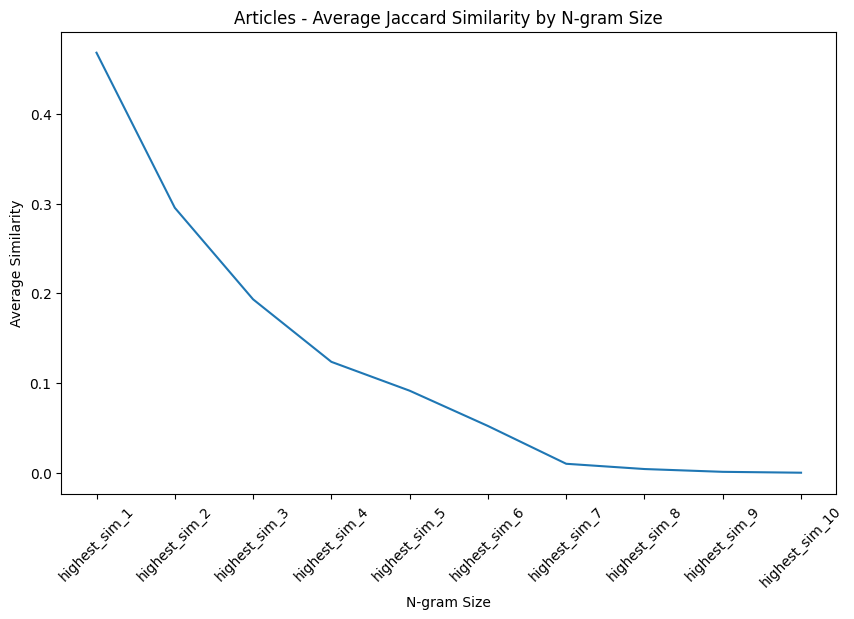

In [213]:
import matplotlib.pyplot as plt

sim_columns = news_df_c.filter(regex='^highest_sim_\d+').columns
avg_sim = news_df_c[sim_columns].mean()

# Plot using seaborn's lineplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
sns.lineplot(data=avg_sim)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel('N-gram Size')  # Set title for the x-axis
plt.ylabel('Average Similarity')  # Set title for the y-axis
plt.title('Articles - Average Jaccard Similarity by N-gram Size')  # Set the title of the plot
plt.show()

### Based on the above plot, I would conclude an ngram value of 4 is best for the article titles. I will continue with this n value going forward.

In [215]:
news_df_c[['highest_sim_4','highest_sim_ind_4','title_clean', 'text_clean']].nlargest(10, 'highest_sim_4')

,highest_sim_4,highest_sim_ind_4,title_clean,text_clean
6,0.857143,349,exnissan us exec kelly gets suspended sentence go home,exnissan us exec kelly gets suspended sentence go home home mail news finance sports entertainment life shopping yahoo plus download yahoo news app yahoo news search query sign mail sign view mail news news us us politics politics world world covid covid climate change climate change originals originals skullduggeryskullduggery conspiracylandconspiracyland health health science science podcasts podcasts contact us contact us videos videos autos autos live updatesukraine says pact reached rus...
349,0.857143,6,exnissan us exec kelly gets suspended sentence go home ourquadcities,exnissan us exec kelly gets suspended sentence go home ourquadcitiesskip contentwhbf ourquadcitiescomrock islandrock islandsponsored toggle menuopen navigationclose navigationsearchplease enter search termprimary menunewslocal newslocal arts culturestate newsrussia ukraine conflict recordlocal news morningnational newsyour local election headquarterswashington dclocal movie reviewsbestreviewspr newswire press releasesweatherdog walking forecastsevere weatherclosings delaysweather camwinter d...
35,0.833333,760,france issues arrest warrant disgraced auto tycoon ghosn,france issues arrest warrant disgraced auto tycoon ghosnlocal newsgeorgia politicsajc podcastsepapercovidsportspress epapernewsall newsgeorgia newsbreaking newslocal newsbusinesseducationweathertrafficinspire atlantacrime public safetynational world newsobituariesajc jobspoliticsall politicspolitical insiderlegislatureelections inside electionnational politicsjamie dupreetake actionpolitically georgia podcastlegislative navigatorlocal newsall county newsalpharettadunwoodyroswellsandy springs...
534,0.833333,760,france issues arrest warrant disgraced auto tycoon ghosn,france issues arrest warrant disgraced auto tycoon ghosn skip main content currently readingfrance issues arrest warrant disgraced auto tycoon ghosnsubscribesubscribeeeditionsign puzzleshomecontact uscirculationnewslettersbreaking news signupprint archivesprivacy noticeterms usenewslocal newsaround thumbtribune throwbackmichiganus worldagriculturebusinesshealthentertainmentspecial sectionssocialsocialopinionopinionprep zoneprep zone bad axeprep zone casevilleprep zone cass cityprep zone deck...
664,0.833333,790,russias war spurs corporate exodus exposes business risks,russias war spurs corporate exodus exposes business risks skip main content currently readingrussias war spurs corporate exodus exposes business riskssubscribesubscribeeeditionsign homeabout uscontact usadvertisesubscribeprivacy noticeterms usenewsarchivesspecial sectionsnews tiponline formsrss feedssportssubmit scoressubmit sports newspronewslettersobituariessubmit obituaryfeaturesgamescontestsspecial sectionscomicshoroscopessubmit anniversarysubmit birthsubmit birthdaysubmit engagementsubm...
760,0.833333,35,france issues arrest warrant disgraced auto tycoon ghosn kesq,france issues arrest warrant disgraced auto tycoon ghosn kesqcirclearrowplay buttonstop buttonchevronrightchevronleftchevronupsearchwarningchevronleftskinnychevronrightskinnyxclockcalendarplaybuttoncancelcircleusertwitterfacebookyoutubeinstagramemaillinkedinhomenewscaliforniacrimecoachella valley questions answerededucationiteam investigationsfestival seasonneighborhood heroessalton sea projectscandal city hallstands youusworldcoronaviruscoronavirus questions answeredlocal resourcesweatheral...
790,0.833333,664,russias war spurs corporate exodus exposes business risks khon,russias war spurs corporate exodus exposes business risks khonskip contentkhonwaipahulive nowkhon news waipahulivesponsored toggle menuopen navigationclose navigationsearchplease enter search termprimary menunewshawaii newscoronavirusnational newswashingtondcinternational newsrussia ukraine conflictaction linealways investigatinghawaii crimekupuna caregiverkupuna lifebusiness mattersaloha authentichardworki

### The highest similarity news articles by their title primarily are centered around france and nissans. A lof of the language between them is expectedly similar.

In [216]:
non_zero_articles = news_df_c[news_df_c['highest_sim_4'] > 0]
non_zero_articles[['highest_sim_4','highest_sim_ind_4', 'title_clean', 'text_clean']].nsmallest(10, 'highest_sim_4')

,highest_sim_4,highest_sim_ind_4,title_clean,text_clean
186,0.041667,396,pm gramin digital saksharta abhiyaan renault india partners csc egovernance services support pm gramin digital saksharta abhiyaan auto news et auto,pm gramin digital saksharta abhiyaan renault india partners csc egovernance services support pm gramin digital saksharta abhiyaan auto news et auto updated terms conditions privacy policy click continue accept continue et autoaccept updated privacy cookie policydear user et auto privacy cookie policy updated align new data regulations european union please review accept changes continue using websiteyou see privacy policy cookie policy use cookies ensure best experience websiteif choose igno...
237,0.047619,396,hero motocorp price hike hero motocorp hike motorcycle scooter prices inr july auto news et auto,hero motocorp price hike hero motocorp hike motorcycle scooter prices inr july auto news et auto updated terms conditions privacy policy click continue accept continue et autoaccept updated privacy cookie policydear user et auto privacy cookie policy updated align new data regulations european union please review accept changes continue using websiteyou see privacy policy cookie policy use cookies ensure best experience websiteif choose ignore message well assume happy receive cookies et aut...
185,0.050000,396,renault exports renaults made india products cross one lakh export milestone auto news et auto,renault exports renaults made india products cross one lakh export milestone auto news et auto updated terms conditions privacy policy click continue accept continue et autoaccept updated privacy cookie policydear user et auto privacy cookie policy updated align new data regulations european union please review accept changes continue using websiteyou see privacy policy cookie policy use cookies ensure best experience websiteif choose ignore message well assume happy receive cookies et autoa...
386,0.050000,396,biofuel us biofuel industry defends record biden administration mulls policy reform auto news et auto,biofuel us biofuel industry defends record biden administration mulls policy reform auto news et auto updated terms conditions privacy policy click continue accept continue et autoaccept updated privacy cookie policydear user et auto privacy cookie policy updated align new data regulations european union please review accept changes continue using websiteyou see privacy policy cookie policy use cookies ensure best experience websiteif choose ignore message well assume happy receive cookies e...
492,0.050000,396,global energy transition global energy transition cause shortterm economic pain report auto news et auto,global energy transition global energy transition cause shortterm economic pain report auto news et auto etautonewsnews passenger vehicle commercial vehicle two wheelers automotive components industry tyres aftermarket policy auto technology people movement oil lubes new launches raw material financial results auto finance featuresfeatures trends autopreneur etauto tv industryspeakindustryspeak interviews autologue etauto insights dealersdata analyticsdata analytics etautolytics reports etau...
660,0.050000,396,india fuel demand india expects fuel demand grow next fiscal year auto news et auto,india fuel demand india expects fuel demand grow next fiscal year auto news et auto updated terms conditions privacy policy click continue accept continue et autoaccept updated privacy cookie policydear user et auto privacy cookie policy updated align new data regulations european union please review accept changes continue using websiteyou see privacy policy cookie policy use cookies ensure best experience websiteif choose ignore message well assume happy receive cookies et autoanalyticsnec...
961,0.052632,396,lg energy solution gm sets bln michigan electric vehicle plants auto news et auto,lg energy solution gm sets bln michigan electric vehicle plants auto news et auto etautonewsnews passenger vehic

### The most dissimilar news articles/titles do not show much relation and span various topics like india, scooter prices, and fuel

## **Summary:** The n for tweets and articles were different. n for tweets was 3 and n for article titles was 4 but it could have been 3 as well. Even though I set them to different n values, they both were close and were smaller than 5 ngrams. This makes sense because tweets and titles in general do not have long text, so setting a 10+ ngram value could encompass the whole text itself in some instances.